In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import statsmodels.api as sm
from sklearn.svm import SVR
import time

In [2]:
Ames_original = pd.read_csv('Ames_HousePrice.csv', index_col=0)

Ames = Ames_original.copy()

In [178]:
# Targeted Feature Engineering
Ames["GrLivArea_per_LotArea"] = Ames["GrLivArea"] / (Ames["LotArea"] + 1)
Ames["TotalSF"] = Ames["GrLivArea"] + Ames["TotalBsmtSF"]
Ames["HouseAge"] = Ames["YrSold"].astype(int) - Ames["YearBuilt"].astype(int)
Ames["HouseAgeSinceRemod"] = Ames["YrSold"].astype(int) - Ames["YearRemodAdd"].astype(int)
Ames["WasRemodeled"] = Ames['YearRemodAdd'] > Ames["YearBuilt"].astype(int)

bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
Ames[bath_cols] = Ames[bath_cols].fillna(0)
# initialize only if not already set
try:
    half_weight
except NameError:
    half_weight = 0.5

try:
    b_weight
except NameError:
    b_weight = 1.0

try:
    b_weight_half
except NameError:
    b_weight_half = 0.5


Ames['TotalBaths'] = Ames['FullBath'] + half_weight * Ames['HalfBath'] + b_weight * Ames['BsmtFullBath'] + b_weight_half * Ames['BsmtHalfBath']

garage_cols = ['GarageArea', 'GarageCars']
Ames[garage_cols] = Ames[garage_cols].fillna(0)

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Ames[basement_cols] = Ames[basement_cols].fillna(0)

Ames['MasVnrArea'] = Ames['MasVnrArea'].fillna(0)
Ames['PoolArea'] = Ames['PoolArea'].fillna(0)

# mapping dictionary
style_map = {
    "1Story": "Ranch",
    "SFoyer": "Ranch",
    "SLvl": "Ranch",
    "2Story": "Colonial",
    "2.5Fin": "Colonial",
    "2.5Unf": "Colonial",
    "1.5Fin": "Other",
    "1.5Unf": "Other"
}

# apply to dataset
Ames["RanchColonial"] = Ames["HouseStyle"].map(style_map)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')
Ames['WasRemodeled'] = Ames['WasRemodeled'].astype('object')


# Add Interactions
Ames['GrLivArea_x_Qual'] = Ames['GrLivArea'] * Ames['OverallQual']
Ames['TotalSF_x_Qual'] = Ames['TotalSF'] * Ames['OverallQual']


X_fe = Ames.drop(columns=['SalePrice','PID'])
y = Ames['SalePrice']

In [38]:
# === ONE-CELL START: encoders + pipelines + CV helper (no-TTR, short params) ===
from __future__ import annotations
import numpy as np
import pandas as pd
from typing import Iterable, Optional, List, Dict, Tuple

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor

# ----------------------------- Ordinal maps -----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# --------------------- Utilities (metrics + helpers) --------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

from pandas.api.types import CategoricalDtype
def _is_object_like(s: pd.Series) -> bool:
    return s.dtype.kind in ("O", "b") or isinstance(s.dtype, CategoricalDtype)

# --------------------------- Quantile capper ----------------------------
class QuantileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q: float = 0.01, upper_q: float = 0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = list(df.columns)
        self.lower_ = df.quantile(self.lower_q)
        self.upper_ = df.quantile(self.upper_q)
        return self

    def transform(self, X):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        df = df.clip(self.lower_, self.upper_, axis=1)
        return df.infer_objects(copy=False)   # <--- this silences the warning

    def get_feature_names_out(self, input_features=None):
        return np.asarray(self.feature_names_in_, dtype=object)

# ------------------------- Preprocessor builder -------------------------
def build_preprocessor(
    df: pd.DataFrame,
    *,
    mode: str = "linear",  # 'linear' -> log/scale; 'tree' -> no log/scale on numerics
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,          # (linear mode only)
    scale_features: Optional[Iterable[str]] = None,    # (linear mode only)
    zero_impute_cols: Optional[Iterable[str]] = None   # exact zeros for these numerics
) -> ColumnTransformer:

    if mode not in {"linear", "tree"}:
        raise ValueError("mode must be 'linear' or 'tree'")

    num_all = df.select_dtypes(include=["number"]).columns.tolist()
    cat_all = [c for c in df.columns if _is_object_like(df[c])]

    ordinal_explicit = [c for c in ORDINAL_ORDER.keys() if c in df.columns and c != "Electrical"]
    nominal_all = [c for c in cat_all if c not in ORDINAL_ORDER.keys()]

    zero_impute_cols = list(zero_impute_cols or ["BsmtFullBath", "BsmtHalfBath"])
    zero_impute_cols = [c for c in zero_impute_cols if c in num_all]

    default_cap = [
        "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
        "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
        "3SsnPorch","ScreenPorch","PoolArea","MiscVal",
        "TotalSF","GrLivArea_per_LotArea",
    ]
    numeric_cap = set(numeric_cap or default_cap) & set(num_all)

    if mode == "linear":
        log_cols = set(log_cols or [
            "LotArea", "LotFrontage", "MasVnrArea",
            "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
            "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
            "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
        ])
        scale_features = set(scale_features or (
            {
                "GrLivArea","LotFrontage","LotArea","MasVnrArea",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
                "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                "ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
            }
            | {"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
               "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
               "GarageCars","TotalBaths"}
            | {"OverallQual","OverallCond"}
            | {"HouseAge","HouseAgeSinceRemod","GarageAge"}
        ))
    else:
        log_cols = set()
        scale_features = set()

    num_log_cap   = sorted((log_cols & numeric_cap) & set(num_all))
    num_log_plain = sorted((log_cols - numeric_cap) & set(num_all))
    num_cap_only  = sorted((numeric_cap - log_cols) & set(num_all))
    used_linear_buckets = set(num_log_cap) | set(num_log_plain) | set(num_cap_only)
    num_plain = sorted([c for c in num_all if c not in used_linear_buckets])

    def make_imputer_for(cols: List[str]) -> ColumnTransformer:
        zero_cols = [c for c in cols if c in zero_impute_cols]
        mean_cols = [c for c in cols if c not in zero_impute_cols]
        transformers = []
        if zero_cols:
            transformers.append(("zero_imp", SimpleImputer(strategy="constant", fill_value=0), zero_cols))
        if mean_cols:
            transformers.append(("mean_imp", SimpleImputer(strategy="mean"), mean_cols))
        return ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

    def numeric_branch(cols: List[str], *, cap: bool, log: bool, scale: bool):
        if not cols:
            return None
        steps = []
        if cap:
            steps.append(("cap", QuantileCapper(lower_q=lower_q, upper_q=upper_q)))
        steps.append(("impute", make_imputer_for(cols)))
        if log:
            steps.append(("log1p", FunctionTransformer(np.log1p, validate=False)))
        if scale:
            steps.append(("scale", StandardScaler()))
        return ("_tmp", Pipeline(steps=steps), cols)

    branches = []
    branches += [numeric_branch(num_log_cap,   cap=True,  log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_log_plain, cap=False, log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_cap_only,  cap=True,  log=False,           scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_plain,     cap=False, log=False,           scale=(mode=="linear"))] or []
    branches = [b for b in branches if b is not None]

    electrical_pipe = Pipeline(steps=[
        ("impute_mf", SimpleImputer(strategy="most_frequent")),
        ("ordinal",   OrdinalEncoder(categories=[ORDINAL_ORDER["Electrical"]],
                                     handle_unknown="use_encoded_value", unknown_value=-1)),
    ]) if "Electrical" in df.columns else "drop"

    if "Electrical" in nominal_all: nominal_all.remove("Electrical")
    if "Electrical" in ordinal_explicit: ordinal_explicit.remove("Electrical")

    ordinal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("ordinal", OrdinalEncoder(categories=[ORDINAL_ORDER[c] for c in ordinal_explicit],
                                       handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        if ordinal_explicit else "drop"
    )

    nominal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
        ])
        if nominal_all else "drop"
    )

    transformers = []
    if "Electrical" in df.columns:
        transformers.append(("elect", electrical_pipe, ["Electrical"]))
    name_map = ["num_log_cap","num_log_plain","num_cap","num_plain"]
    for i, b in enumerate(branches):
        transformers.append((name_map[i], b[1], b[2]))
    if ordinal_explicit:
        transformers.append(("ordinal", ordinal_pipe, ordinal_explicit))
    if nominal_all:
        transformers.append(("nominal", nominal_pipe, nominal_all))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        sparse_threshold=0.3,
        verbose_feature_names_out=False
    )
    return pre

# ------------------------- Pipeline factories --------------------------
def make_linear_pipe(
    df_schema: pd.DataFrame,
    *,
    model: str = "ridge",                     # 'ridge' | 'lasso' | 'enet'  (pass kwargs via model_kwargs)
    model_kwargs: Optional[dict] = None,
    # preprocessing knobs (optional; use defaults if omitted)
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,
    scale_features: Optional[Iterable[str]] = None,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Linear pipeline with fold-safe preprocessing. NO TTR — keep params short (reg__alpha etc).
    Target logging is handled by the evaluator.
    """
    model_kwargs = model_kwargs or {}
    key = (model or "").lower()
    if key == "ridge":
        model_kwargs = dict(model_kwargs or {})
        model_kwargs.setdefault("max_iter", 200_000)
        model_kwargs.setdefault("tol", 1e-3)
        base = Ridge(**model_kwargs)
    elif key == "lasso":
        base = Lasso(max_iter=200_000, tol=1e-3, **model_kwargs)
    elif key == "enet":
        base = ElasticNet(max_iter=200_000, tol=1e-3, **model_kwargs)
    else:
        raise ValueError("model must be 'ridge' | 'lasso' | 'enet'")

    pre = build_preprocessor(
        df_schema, mode="linear",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=log_cols, scale_features=scale_features,
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", base)])

def make_histgb_pipe(
    df_schema: pd.DataFrame,
    *,
    hgb_kwargs: Optional[dict] = None,
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Tree pipeline: cap + impute + encoders; NO log/scale on features.
    """
    hgb_kwargs = hgb_kwargs or {"random_state": 42}
    pre = build_preprocessor(
        df_schema, mode="tree",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=[], scale_features=[],
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", HistGradientBoostingRegressor(**hgb_kwargs))])

# ---------------------- Quick CV leaderboard helper --------------------
def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: List[Tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,     # <— evaluator handles log target (since no TTR)
) -> pd.DataFrame:

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rows = []

    for name, est in models:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        for tr, va in kf.split(X):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(rmse(y_va, pred))
            oof[va] = pred

        # full-fit for r2_full
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

# ------------------------------- Demo use -------------------------------
# Example:
# LOG_COLS = ["LotArea","LotFrontage","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
#             "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
#             "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea"]
# SCALE_FEATURES = LOG_COLS + ["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr",
#                               "KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","TotalBaths",
#                               "OverallQual","OverallCond","HouseAge","HouseAgeSinceRemod","GarageAge"]
# CAP_COLS = ["LotArea","LotFrontage","MasVnrArea","TotalBsmtSF","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
#             "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
#             "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea"]
# ZERO_IMPUTE = ["BsmtFullBath","BsmtHalfBath"]

# ridge = make_linear_pipe(X_fe, model="ridge", model_kwargs={"alpha": 12.0},
#                          numeric_cap=CAP_COLS, log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
#                          zero_impute_cols=ZERO_IMPUTE)
# enet  = make_linear_pipe(X_fe, model="enet",  model_kwargs={"alpha": 0.01, "l1_ratio": 0.3},
#                          numeric_cap=CAP_COLS, log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
#                          zero_impute_cols=ZERO_IMPUTE)
# hgb   = make_histgb_pipe(X_fe, hgb_kwargs={"random_state":42, "max_iter":800},
#                          numeric_cap=CAP_COLS, zero_impute_cols=ZERO_IMPUTE)

# models = [("Ridge (log+cap+scale)", ridge),
#           ("ElasticNet (log+cap+scale)", enet),
#           ("HistGB (cap only)", hgb)]
# print(cv_eval_models(X=X_fe, y=y, models=models, cv=5, log_target=True))
# === ONE-CELL END ===

In [179]:
LOG_COLS = ["LotArea","LotFrontage","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
            "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea"]
SCALE_FEATURES = LOG_COLS + ["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr",
                              "KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","TotalBaths",
                              "OverallQual","OverallCond","HouseAge","HouseAgeSinceRemod","GarageAge"]
CAP_COLS = ["LotArea","LotFrontage","MasVnrArea","TotalBsmtSF","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
            "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea"]
ZERO_IMPUTE = ["BsmtFullBath","BsmtHalfBath"]

ridge = make_linear_pipe(X_fe, model="ridge", model_kwargs={"alpha": 12.0},
                         numeric_cap=CAP_COLS, log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
                         zero_impute_cols=ZERO_IMPUTE)
enet  = make_linear_pipe(X_fe, model="enet",  model_kwargs={"alpha": 0.01, "l1_ratio": 0.3},
                         numeric_cap=CAP_COLS, log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
                         zero_impute_cols=ZERO_IMPUTE)
hgb   = make_histgb_pipe(X_fe, hgb_kwargs={"random_state":42, "max_iter":800},
                         numeric_cap=CAP_COLS, zero_impute_cols=ZERO_IMPUTE)

models = [("Ridge (log+cap+scale)", ridge),
          ("ElasticNet (log+cap+scale)", enet),
          ("HistGB (cap only)", hgb)]
print(cv_eval_models(X=X_fe, y=y, models=models, cv=5, log_target=True))

                        model  cv_rmse_mean  cv_rmse_std     r2_cv   r2_full
0       Ridge (log+cap+scale)  21716.320420  4861.431265  0.911998  0.940162
1           HistGB (cap only)  21942.302526  3091.927050  0.912745  0.999872
2  ElasticNet (log+cap+scale)  24072.413518  5215.824103  0.892192  0.910012


In [180]:
pd.set_option("future.no_silent_downcasting", True)
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform, uniform

# --- Ridges ---
alphas = np.logspace(-2, 3, 30)   # 0.01 → 1000
ridge_grid = GridSearchCV(
    make_linear_pipe(X_fe, model="ridge",
                     numeric_cap=CAP_COLS,
                     log_cols=LOG_COLS,
                     scale_features=SCALE_FEATURES,
                     zero_impute_cols=ZERO_IMPUTE),
    param_grid={"reg__alpha": alphas},
    cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
)
ridge_grid.fit(X_fe, np.log1p(y))   # log-target here because gridsearch doesn’t know about our evaluator
print("Best Ridge alpha:", ridge_grid.best_params_)
print("Best Ridge CV RMSE:", -ridge_grid.best_score_)


# --- ElasticNet ---
enet_grid = GridSearchCV(
    make_linear_pipe(X_fe, model="enet",
                     numeric_cap=CAP_COLS,
                     log_cols=LOG_COLS,
                     scale_features=SCALE_FEATURES,
                     zero_impute_cols=ZERO_IMPUTE),
    param_grid={
        "reg__alpha": np.logspace(-3, 1, 20),   # 0.001 → 10
        "reg__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.0]
    },
    cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
)
enet_grid.fit(X_fe, np.log1p(y))
print("Best ElasticNet params:", enet_grid.best_params_)
print("Best ElasticNet CV RMSE:", -enet_grid.best_score_)


# --- HistGB ---
hgb_random = RandomizedSearchCV(
    make_histgb_pipe(X_fe, hgb_kwargs={"random_state":42, "max_iter":800},
                     numeric_cap=CAP_COLS,
                     zero_impute_cols=ZERO_IMPUTE),
    param_distributions={
        "reg__max_depth": [3, 5, 7, None],
        "reg__learning_rate": loguniform(0.01, 0.2),
        "reg__max_leaf_nodes": [15, 31, 63, None],
        "reg__min_samples_leaf": [5, 10, 20, 50],
    },
    n_iter=25, cv=5, scoring="neg_root_mean_squared_error",
    n_jobs=-1, random_state=42
)
hgb_random.fit(X_fe, y)   # no log target for trees
print("Best HistGB params:", hgb_random.best_params_)
print("Best HistGB CV RMSE:", -hgb_random.best_score_)

warnings.resetwarnings()

Best Ridge alpha: {'reg__alpha': np.float64(18.873918221350976)}
Best Ridge CV RMSE: 0.10478552058106376
Best ElasticNet params: {'reg__alpha': np.float64(0.001623776739188721), 'reg__l1_ratio': 0.1}
Best ElasticNet CV RMSE: 0.1056171339686518
Best HistGB params: {'reg__learning_rate': np.float64(0.061721159481070736), 'reg__max_depth': 3, 'reg__max_leaf_nodes': 15, 'reg__min_samples_leaf': 20}
Best HistGB CV RMSE: 21048.35251564549


In [183]:
import warnings
warnings.filterwarnings("ignore", module='sklearn')

# Collect tuned best models
ridge_best = ridge_grid.best_estimator_
enet_best  = enet_grid.best_estimator_
hgb_best   = hgb_random.best_estimator_

# Compare all side by side
models = [
    ("Ridge tuned", ridge_best),
    ("ElasticNet tuned", enet_best),
    ("HistGB tuned", hgb_best),
]

print(cv_eval_models(X=X_fe, y=y, models=models, cv=5))

              model  cv_rmse_mean  cv_rmse_std     r2_cv   r2_full
0      HistGB tuned  21174.541039  3442.423257  0.918221  0.980088
1       Ridge tuned  21747.012878  4911.535945  0.911674  0.938428
2  ElasticNet tuned  22056.367592  5046.477104  0.909027  0.937909


In [185]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

hgb_pipe = make_histgb_pipe(
    X_fe,
    hgb_kwargs={"random_state": 42, "early_stopping": "auto", "max_iter": 1500}
)

param_dist = {
    "reg__learning_rate": loguniform(0.01, 0.3),  # explore smaller rates
    "reg__max_depth": randint(2, 8),
    "reg__max_leaf_nodes": randint(15, 63),
    "reg__min_samples_leaf": randint(5, 40),
    "reg__l2_regularization": loguniform(1e-8, 1e-1),
    "reg__max_bins": randint(128, 255),           # finer histograms can help
}

hgb_rand = RandomizedSearchCV(
    hgb_pipe,
    param_distributions=param_dist,
    n_iter=60,               # bump if you have time
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

hgb_rand.fit(X_fe, y)
print("Best HGB params:", hgb_rand.best_params_)
print("Best HGB CV RMSE:", -hgb_rand.best_score_)
hgb_best = hgb_rand.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/var/folders/jp/xgt314z12mgc2qh1wbn4mbx40000gn/T/ipykernel_65017/3532232782.py:66: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/jp/xgt314z12mgc2qh1wbn4mbx40000gn/T/ipykernel_65017/3532232782.py:66: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/jp/xgt314z12mgc2qh1wbn4mbx400

Best HGB params: {'reg__l2_regularization': np.float64(0.00026677234978367633), 'reg__learning_rate': np.float64(0.0862581622692092), 'reg__max_bins': 138, 'reg__max_depth': 2, 'reg__max_leaf_nodes': 23, 'reg__min_samples_leaf': 10}
Best HGB CV RMSE: 20957.34646997842


In [187]:
warnings.filterwarnings("ignore")

from sklearn.compose import TransformedTargetRegressor
import numpy as np

hgb_logy = TransformedTargetRegressor(
    regressor=make_histgb_pipe(
        X_fe, hgb_kwargs={"random_state": 42, "early_stopping": "auto", "max_iter": 1500}
    ),
    func=np.log1p, inverse_func=np.expm1
)

# You can tune it the same way; just prefix params with "regressor__"
param_dist_logy = {
    "regressor__reg__learning_rate": loguniform(0.01, 0.3),
    "regressor__reg__max_depth": randint(2, 8),
    "regressor__reg__max_leaf_nodes": randint(15, 63),
    "regressor__reg__min_samples_leaf": randint(5, 40),
    "regressor__reg__l2_regularization": loguniform(1e-8, 1e-1),
    "regressor__reg__max_bins": randint(128, 255),
}

hgb_rand_logy = RandomizedSearchCV(
    hgb_logy, param_distributions=param_dist_logy,
    n_iter=40, scoring="neg_root_mean_squared_error",
    cv=5, n_jobs=-1, random_state=42, verbose=1
)
hgb_rand_logy.fit(X_fe, y)
print("Best HGB+logy params:", hgb_rand_logy.best_params_)
print("Best HGB+logy CV RMSE:", -hgb_rand_logy.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best HGB+logy params: {'regressor__reg__l2_regularization': np.float64(1.8740223688836284e-07), 'regressor__reg__learning_rate': np.float64(0.018659959624904916), 'regressor__reg__max_bins': 203, 'regressor__reg__max_depth': 3, 'regressor__reg__max_leaf_nodes': 36, 'regressor__reg__min_samples_leaf': 29}
Best HGB+logy CV RMSE: 20474.75751732146


In [188]:
models = [
    ("HistGB tuned", hgb_best),
    ("Ridge tuned", ridge_grid.best_estimator_),
    ("ElasticNet tuned", enet_grid.best_estimator_),
    # Optional:
    ("HistGB tuned (log y)", hgb_rand_logy.best_estimator_),
]
print(cv_eval_models(X=X_fe, y=y, models=models, cv=5).to_string(index=False))

               model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
        HistGB tuned  20632.194708  3591.196377 0.922064 0.981107
HistGB tuned (log y)  21284.685307  3426.738054 0.917409 0.965327
         Ridge tuned  21747.012878  4911.535945 0.911674 0.938428
    ElasticNet tuned  22056.367592  5046.477104 0.909027 0.937909


In [190]:
# --- BLEND: Ridge (log+cap+scale) + HistGB (cap only) ---

import numpy as np
from sklearn.ensemble import VotingRegressor

# 1) Recreate tuned single models
ridge_best = make_linear_pipe(
    X_fe,
    model="ridge",
    model_kwargs={"alpha": 18.873918221350976, "max_iter": 200_000, "tol": 1e-3},
    # you can pass zero_impute_cols if you overrode earlier; defaults already handle BsmtFull/HalfBath=0
)

# Use the *earlier better* HGB settings (the ones you said you prefer) + max_iter=1500
hgb_best = make_histgb_pipe(
    X_fe,
    hgb_kwargs={
        "random_state": 42,
        "max_iter": 1500,
        "learning_rate": 0.018659959624904916,
        "max_depth": 3,
        "max_leaf_nodes": 36,
        "min_samples_leaf": 29,
        "max_bins": 203,
        "l2_regularization": 1.8740223688836284e-07,
        # any other defaults you want to lock can go here
    },
)

# 2) Simple fixed-weight blend (start with 80% HGB / 20% Ridge)
blend_80_20 = VotingRegressor(
    estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
    weights=[0.2, 0.8]
)

# 3) (Optional) Quick weight sweep to see what blends best on CV
weight_grid = np.linspace(0.0, 1.0, 11)  # 0.0..1.0 step 0.1
blend_rows = []
for w in weight_grid:
    w_ridge, w_hgb = float(w), float(1.0 - w)
    est = VotingRegressor(
        estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
        weights=[w_ridge, w_hgb]
    )
    res = cv_eval_models(
        X=X_fe, y=y,
        models=[(f"Blend w_ridge={w_ridge:.1f} w_hgb={w_hgb:.1f}", est)],
        cv=10, random_state=42
    )
    blend_rows.append(res)

blend_table = pd.concat(blend_rows, ignore_index=True).sort_values("cv_rmse_mean")
print(blend_table.to_string(index=False))

# 4) Also compare against the base models so you can confirm the blend helps
baseline_table = cv_eval_models(
    X=X_fe, y=y, cv=10, random_state=42,
    models=[
        ("Ridge tuned", ridge_best),
        ("HistGB tuned (best prior)", hgb_best),
        ("Blend 20/80", blend_80_20),
    ]
)
print("\n=== Baselines vs Blend ===")
print(baseline_table.to_string(index=False))

                      model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
Blend w_ridge=0.4 w_hgb=0.6  20054.658420  4611.672369 0.924752 0.960089
Blend w_ridge=0.5 w_hgb=0.5  20068.649418  4849.279688 0.924253 0.957568
Blend w_ridge=0.3 w_hgb=0.7  20106.712244  4390.208688 0.924735 0.962181
Blend w_ridge=0.6 w_hgb=0.4  20148.513218  5101.466963 0.923236 0.954617
Blend w_ridge=0.2 w_hgb=0.8  20224.488917  4186.328701 0.924201 0.963846
Blend w_ridge=0.7 w_hgb=0.3  20293.591393  5366.623489 0.921700 0.951232
Blend w_ridge=0.1 w_hgb=0.9  20407.183599  4001.275388 0.923152 0.965084
Blend w_ridge=0.8 w_hgb=0.2  20502.764598  5643.165553 0.919643 0.947410
Blend w_ridge=0.0 w_hgb=1.0  20653.538092  3836.028999 0.921584 0.965895
Blend w_ridge=0.9 w_hgb=0.1  20774.494042  5929.602210 0.917061 0.943144
Blend w_ridge=1.0 w_hgb=0.0  21106.876087  6224.588531 0.913950 0.938428

=== Baselines vs Blend ===
                    model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
              Blend 20/80

In [42]:
# --- BLEND: Ridge (log+cap+scale) + HistGB (cap only) ---

import numpy as np
from sklearn.ensemble import VotingRegressor

# 1) Recreate tuned single models
ridge_best = make_linear_pipe(
    X_fe,
    model="ridge",
    model_kwargs={"alpha": 18.873918221350976, "max_iter": 200_000, "tol": 1e-3},
    # you can pass zero_impute_cols if you overrode earlier; defaults already handle BsmtFull/HalfBath=0
)

# Use the *earlier better* HGB settings (the ones you said you prefer) + max_iter=1500
hgb_best = make_histgb_pipe(
    X_fe,
    hgb_kwargs={
        "random_state": 42,
        "max_iter": 1500,
        "learning_rate": 0.018659959624904916,
        "max_depth": 3,
        "max_leaf_nodes": 36,
        "min_samples_leaf": 29,
        "max_bins": 203,
        "l2_regularization": 1.8740223688836284e-07,
        # any other defaults you want to lock can go here
    },
)

# 2) Simple fixed-weight blend (start with 80% HGB / 20% Ridge)
blend_80_20 = VotingRegressor(
    estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
    weights=[0.2, 0.8]
)

# 3) (Optional) Quick weight sweep to see what blends best on CV
weight_grid = np.linspace(0.0, 1.0, 11)  # 0.0..1.0 step 0.1
blend_rows = []
for w in weight_grid:
    w_ridge, w_hgb = float(w), float(1.0 - w)
    est = VotingRegressor(
        estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
        weights=[w_ridge, w_hgb]
    )
    res = cv_eval_models(
        X=X_fe, y=y,
        models=[(f"Blend w_ridge={w_ridge:.1f} w_hgb={w_hgb:.1f}", est)],
        cv=10, random_state=42
    )
    blend_rows.append(res)

blend_table = pd.concat(blend_rows, ignore_index=True).sort_values("cv_rmse_mean")
print(blend_table.to_string(index=False))

# 4) Also compare against the base models so you can confirm the blend helps
baseline_table = cv_eval_models(
    X=X_fe, y=y, cv=10, random_state=42,
    models=[
        ("Ridge tuned", ridge_best),
        ("HistGB tuned (best prior)", hgb_best),
        ("Blend 20/80", blend_80_20),
    ]
)
print("\n=== Baselines vs Blend ===")
print(baseline_table.to_string(index=False))

                      model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
Blend w_ridge=0.4 w_hgb=0.6  20066.170617  4578.543361 0.924724 0.959813
Blend w_ridge=0.5 w_hgb=0.5  20078.477754  4823.102155 0.924228 0.957321
Blend w_ridge=0.3 w_hgb=0.7  20119.627612  4349.742525 0.924705 0.961882
Blend w_ridge=0.6 w_hgb=0.4  20156.465965  5081.714992 0.923215 0.954405
Blend w_ridge=0.2 w_hgb=0.8  20238.439915  4138.349182 0.924172 0.963530
Blend w_ridge=0.7 w_hgb=0.3  20299.562472  5352.697425 0.921684 0.951062
Blend w_ridge=0.1 w_hgb=0.9  20421.723625  3945.879658 0.923124 0.964757
Blend w_ridge=0.8 w_hgb=0.2  20506.725743  5634.450156 0.919631 0.947288
Blend w_ridge=0.0 w_hgb=1.0  20668.154433  3773.636140 0.921561 0.965562
Blend w_ridge=0.9 w_hgb=0.1  20776.483789  5925.513448 0.917055 0.943078
Blend w_ridge=1.0 w_hgb=0.0  21106.987100  6224.608074 0.913949 0.938428

=== Baselines vs Blend ===
                    model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
              Blend 20/80

In [191]:
final_blend = VotingRegressor(
    estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
    weights=[0.4, 0.6]
)

In [192]:
# final training on ALL data
final_blend = VotingRegressor(
    estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
    weights=[0.4, 0.6]
)
final_blend.fit(X_fe, y)
# optionally save it:
import joblib
joblib.dump(final_blend, "final_blend_40_60.joblib")

['final_blend_40_60.joblib']

In [193]:
# quick full-data fit metrics (just to log, not for model selection)
y_hat_full = final_blend.predict(X_fe)
print("Full-data R²:", r2_score(y, y_hat_full))
print("Full-data RMSE:", rmse(y, y_hat_full))

Full-data R²: 0.9591316966018825
Full-data RMSE: 15165.277950539003


In [194]:
from sklearn.model_selection import RepeatedKFold
import numpy as np
import pandas as pd

def eval_blend_weights(X, y, ridge_pipe, hgb_pipe, weights, n_splits=5, n_repeats=3, random_state=42):
    """
    Evaluate a list of blend weights under repeated CV.
    Returns DataFrame with mean/stdev RMSE and R² across all folds/repeats.
    """
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    rows = []
    
    for w_ridge, w_hgb in weights:
        rmses, r2s = [], []
        for tr_idx, va_idx in rkf.split(X):
            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
            
            # fit both base models
            ridge_pipe.fit(X_tr, y_tr)
            hgb_pipe.fit(X_tr, y_tr)
            
            # blend predictions
            pred_ridge = ridge_pipe.predict(X_va)
            pred_hgb   = hgb_pipe.predict(X_va)
            pred = w_ridge * pred_ridge + w_hgb * pred_hgb
            
            # metrics
            rmse = np.sqrt(np.mean((y_va - pred)**2))
            r2   = 1 - np.sum((y_va - pred)**2) / np.sum((y_va - np.mean(y_va))**2)
            
            rmses.append(rmse)
            r2s.append(r2)
        
        rows.append({
            "w_ridge": w_ridge, "w_hgb": w_hgb,
            "rmse_mean": np.mean(rmses), "rmse_std": np.std(rmses),
            "r2_mean": np.mean(r2s), "r2_std": np.std(r2s)
        })
    
    return pd.DataFrame(rows).sort_values("rmse_mean").reset_index(drop=True)

# Example: fine grid around 0.35–0.45 ridge weight
weights = [(w, 1-w) for w in np.linspace(0.35, 0.45, 11)]

results = eval_blend_weights(X_fe, y, ridge_best, hgb_best, weights, n_splits=5, n_repeats=3)
print(results)

    w_ridge  w_hgb     rmse_mean     rmse_std   r2_mean    r2_std
0      0.35   0.65  21326.825241  3436.732365  0.916616  0.028763
1      0.36   0.64  21329.336270  3456.129605  0.916565  0.028992
2      0.37   0.63  21332.773106  3475.530306  0.916507  0.029222
3      0.38   0.62  21337.135904  3494.930730  0.916442  0.029453
4      0.39   0.61  21342.424699  3514.327214  0.916370  0.029685
5      0.40   0.60  21348.639409  3533.716172  0.916290  0.029918
6      0.41   0.59  21355.779828  3553.094098  0.916203  0.030152
7      0.42   0.58  21363.845632  3572.457559  0.916109  0.030387
8      0.43   0.57  21372.836377  3591.803202  0.916008  0.030623
9      0.44   0.56  21382.751498  3611.127750  0.915899  0.030860
10     0.45   0.55  21393.590308  3630.428006  0.915784  0.031098


In [195]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

def eval_blend_weights(
    X, y,
    *,
    ridge_pipe=None, hgb_pipe=None,        # preferred names
    ridge_model=None, hgb_model=None,      # aliases (either pair is OK)
    w_min=0.0, w_max=1.0, step=0.1,
    cv=5, random_state=42
):
    """
    Sweep blend weights between Ridge and HGB pipelines and report CV RMSE/R2.
    Returns a DataFrame with columns: w_ridge, w_hgb, rmse_mean, rmse_std, r2_mean, r2_std.
    """
    # accept aliases
    if ridge_pipe is None and ridge_model is not None:
        ridge_pipe = ridge_model
    if hgb_pipe is None and hgb_model is not None:
        hgb_pipe = hgb_model

    if ridge_pipe is None or hgb_pipe is None:
        raise ValueError("Provide both ridge_pipe and hgb_pipe (or ridge_model/hgb_model).")

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    # pre-fit predictions per fold for speed (fit each model once per fold)
    ridge_preds_folds, hgb_preds_folds = [], []
    for tr, va in kf.split(X):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y_np[tr], y_np[va]

        r = clone(ridge_pipe)
        r.fit(X_tr, y_tr)
        ridge_preds_folds.append((va, r.predict(X_va)))

        h = clone(hgb_pipe)
        h.fit(X_tr, y_tr)
        hgb_preds_folds.append((va, h.predict(X_va)))

    rows = []
    # make weight grid (inclusive of w_max within floating-point tolerance)
    ws = np.arange(w_min, w_max + 1e-12, step).round(10)
    for w in ws:
        fold_rmses, fold_r2s = [], []
        for (va_idx_r, rpred), (va_idx_h, hpred) in zip(ridge_preds_folds, hgb_preds_folds):
            # safety: ensure same validation indices
            if not np.array_equal(va_idx_r, va_idx_h):
                raise RuntimeError("CV split mismatch between models.")
            y_va = y_np[va_idx_r]
            blend = w * rpred + (1.0 - w) * hpred
            fold_rmses.append(np.sqrt(mean_squared_error(y_va, blend)))
            fold_r2s.append(r2_score(y_va, blend))

        rows.append({
            "w_ridge": float(w),
            "w_hgb": float(1.0 - w),
            "rmse_mean": float(np.mean(fold_rmses)),
            "rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_mean":   float(np.mean(fold_r2s)),
            "r2_std":    float(np.std(fold_r2s, ddof=0)),
        })

    return pd.DataFrame(rows).sort_values("rmse_mean").reset_index(drop=True)

def find_best_blend_weight(
    X, y, *, ridge_pipe, hgb_pipe, cv=5, random_state=42,
    coarse=(0.1, 0.9, 0.1), fine=(0.3, 0.7, 0.02), ultra=(0.34, 0.46, 0.005)
):
    """
    Multi-stage search: coarse -> fine -> ultra. Returns (best_w, table).
    """
    tables = []
    for (a, b, s) in (coarse, fine, ultra):
        tbl = eval_blend_weights(
            X, y, ridge_pipe=ridge_pipe, hgb_pipe=hgb_pipe,
            w_min=a, w_max=b, step=s, cv=cv, random_state=random_state
        )
        tables.append(tbl)
        # narrow around current best for the next stage
        wbest = tbl.loc[tbl["rmse_mean"].idxmin(), "w_ridge"]
        a, b = max(0.0, wbest - s*2), min(1.0, wbest + s*2)
    all_tbl = pd.concat(tables, ignore_index=True).drop_duplicates(["w_ridge"]).sort_values("rmse_mean")
    return float(all_tbl.iloc[0]["w_ridge"]), all_tbl

In [196]:
class FittedWeightedBlend:
    """Wrap two already-configured pipelines, fit on full data, and blend at predict time."""
    def __init__(self, ridge_pipe, hgb_pipe, w_ridge: float):
        self.ridge = ridge_pipe
        self.hgb   = hgb_pipe
        self.w_ridge = float(w_ridge)
        self.w_hgb   = 1.0 - self.w_ridge

    def fit(self, X, y):
        self.ridge.fit(X, y)
        self.hgb.fit(X, y)
        return self

    def predict(self, X):
        return self.w_ridge * self.ridge.predict(X) + self.w_hgb * self.hgb.predict(X)

# Pick best weight from results and fit final model on all data
best_w = results.loc[results["rmse_mean"].idxmin(), "w_ridge"]
final_blend = FittedWeightedBlend(ridge_best, hgb_best, best_w).fit(X_fe, y)

# Sanity check: full-data metrics
from sklearn.metrics import mean_squared_error, r2_score
y_hat_full = final_blend.predict(X_fe)
print("Full-data R²:", r2_score(y, y_hat_full))
print("Full-data RMSE:", np.sqrt(mean_squared_error(y, y_hat_full)))

Full-data R²: 0.9610231961809862
Full-data RMSE: 14810.174707087821


In [197]:
best_row = results.loc[results["rmse_mean"].idxmin()]
best_w  = float(best_row["w_ridge"])
print(f"Best so far → w_ridge={best_w:.3f}, w_hgb={1-best_w:.3f}")

Best so far → w_ridge=0.350, w_hgb=0.650


In [198]:
fine = eval_blend_weights(
    X=X_fe, y=y,
    ridge_pipe=ridge_best, hgb_pipe=hgb_best,
    w_min=0.30, w_max=0.35, step=0.005,
    cv=5, random_state=42
)
best_fine = fine.loc[fine["rmse_mean"].idxmin()]
print(best_fine[["w_ridge","w_hgb","rmse_mean","r2_mean"]])

w_ridge          0.325000
w_hgb            0.675000
rmse_mean    21344.584836
r2_mean          0.917685
Name: 0, dtype: float64


In [199]:
best_w, tbl = find_best_blend_weight(
    X=X_fe, y=y,
    ridge_pipe=ridge_best, hgb_pipe=hgb_best,
    cv=5, random_state=42,
    coarse=(0.2, 0.8, 0.1), fine=(0.3, 0.7, 0.02), ultra=(0.34, 0.46, 0.005)
)
print("Best w_ridge:", best_w, "w_hgb:", 1-best_w)
tbl.head(10)

Best w_ridge: 0.32 w_hgb: 0.6799999999999999


,w_ridge,w_hgb,rmse_mean,rmse_std,r2_mean,r2_std
7,0.320,0.680,21344.741238,3770.640221,0.917692,0.023585
8,0.340,0.660,21345.544083,3799.844646,0.917652,0.023910
29,0.345,0.655,21346.340090,3807.151985,0.917638,0.023992
30,0.350,0.650,21347.374260,3814.461308,0.917622,0.024074
0,0.300,0.700,21347.746269,3741.488103,0.917701,0.023264
31,0.355,0.645,21348.646601,3821.772361,0.917604,0.024156
10,0.360,0.640,21350.157115,3829.084896,0.917584,0.024238
33,0.365,0.635,21351.905793,3836.398663,0.917562,0.024321
34,0.370,0.630,21353.892620,3843.713416,0.917538,0.024404
35,0.375,0.625,21356.117574,3851.028909,0.917513,0.024487


In [200]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import numpy as np
import os

class FixedBlend(BaseEstimator, RegressorMixin):
    def __init__(self, ridge_pipe, hgb_pipe, w_ridge=0.325):
        self.ridge_pipe = ridge_pipe
        self.hgb_pipe = hgb_pipe
        self.w_ridge = float(w_ridge)

    def fit(self, X, y):
        self.ridge_ = clone(self.ridge_pipe).fit(X, y)
        self.hgb_   = clone(self.hgb_pipe).fit(X, y)
        return self

    def predict(self, X):
        pr = self.ridge_.predict(X)
        ph = self.hgb_.predict(X)
        return self.w_ridge * pr + (1.0 - self.w_ridge) * ph

# 1) Reuse your tuned single models (already defined as ridge_best, hgb_best)
w_best = 0.325   # or 0.33 if you prefer a rounder number

final_blend = FixedBlend(ridge_pipe=ridge_best, hgb_pipe=hgb_best, w_ridge=w_best)
final_blend.fit(X_fe, y)

# 2) Sanity-check on the full training set
pred_full = final_blend.predict(X_fe)
r2_full   = r2_score(y, pred_full)
rmse_full = float(np.sqrt(mean_squared_error(y, pred_full)))
print(f"Full-data R²: {r2_full:.6f}")
print(f"Full-data RMSE: {rmse_full:.2f}")

# 3) Save the fitted blender
os.makedirs("models", exist_ok=True)
joblib.dump(final_blend, f"models/blend_ridge_hgb_w{w_best:.3f}.joblib")
print("Saved:", f"models/blend_ridge_hgb_w{w_best:.3f}.joblib")

Full-data R²: 0.961907
Full-data RMSE: 14641.27
Saved: models/blend_ridge_hgb_w0.325.joblib


In [201]:
def confirm_blend_cv(X, y, ridge_pipe, hgb_pipe, w_ridge, cv=10, random_state=42):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rmses, r2s = [], []
    for tr, va in kf.split(X):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        rid = clone(ridge_pipe).fit(X_tr, y_tr)
        hgb = clone(hgb_pipe).fit(X_tr, y_tr)
        pred = w_ridge * rid.predict(X_va) + (1 - w_ridge) * hgb.predict(X_va)
        rmses.append(np.sqrt(mean_squared_error(y_va, pred)))
        r2s.append(r2_score(y_va, pred))
    return np.mean(rmses), np.std(rmses), np.mean(r2s), np.std(r2s)

rm, rs, r2m, r2s = confirm_blend_cv(X_fe, y, ridge_best, hgb_best, w_best, cv=10, random_state=42)
print(f"CV RMSE mean={rm:.2f} std={rs:.2f} | CV R² mean={r2m:.6f} std={r2s:.6f}")

CV RMSE mean=20857.62 std=4579.22 | CV R² mean=0.917121 std=0.046342


In [202]:
def _feature_names_from_pre(pre):
    """
    Build output feature names from a fitted ColumnTransformer `pre`
    that contains:
      - numeric branches (pipelines with cap/log/scale): one-to-one → keep original names
      - 'elect' ordinal pipeline: 1 col → keep original name
      - 'ordinal' pipeline (OrdinalEncoder over several cols): one-to-one → keep original names
      - 'nominal' pipeline with OneHotEncoder: ask OHE for names
    """
    names = []
    for name, trans, cols in pre.transformers_:
        if trans == "drop" or cols is None:
            continue
        # Normalize cols to list
        if isinstance(cols, (str, int)):
            cols_list = [cols]
        else:
            cols_list = list(cols)

        if name == "nominal":
            # Pipeline(..., onehot=OneHotEncoder)
            try:
                ohe = trans.named_steps.get("onehot", None)
            except Exception:
                ohe = None
            if ohe is not None and hasattr(ohe, "get_feature_names_out"):
                names.extend(list(ohe.get_feature_names_out(cols_list)))
            else:
                names.extend([str(c) for c in cols_list])
        elif name in ("ordinal", "elect"):
            # OrdinalEncoder is one-to-one over input columns
            names.extend([str(c) for c in cols_list])
        else:
            # numeric branches: one-to-one after cap/log/scale
            names.extend([str(c) for c in cols_list])
    return np.asarray(names, dtype=object)


def extract_linear_coefs(estimator, top=None, sort_by="abs", as_frame=True):
    """
    Works for:
      - TransformedTargetRegressor(regressor=Pipeline([('prep', ColumnTransformer), ('reg', Ridge/Lasso/ENet)]))
      - Pipeline([('prep', ColumnTransformer), ('reg', ...)])
    Returns (df, intercept) or (series, intercept).
    """
    from sklearn.pipeline import Pipeline
    from sklearn.compose import TransformedTargetRegressor

    # unwrap to Pipeline
    if isinstance(estimator, TransformedTargetRegressor):
        pipe = estimator.regressor_
    elif isinstance(estimator, Pipeline):
        pipe = estimator
    else:
        raise TypeError("Pass a fitted TransformedTargetRegressor or Pipeline containing ('prep','reg').")

    if "prep" not in pipe.named_steps or "reg" not in pipe.named_steps:
        raise ValueError("Pipeline must contain steps named 'prep' and 'reg'.")

    prep = pipe.named_steps["prep"]
    reg  = pipe.named_steps["reg"]

    # get names robustly (avoid FunctionTransformer issue)
    feature_names = _feature_names_from_pre(prep)

    if not hasattr(reg, "coef_"):
        raise AttributeError("Final estimator has no coef_. Is it fitted and linear?")
    coefs = np.ravel(reg.coef_)
    if coefs.shape[0] != len(feature_names):
        raise ValueError(f"coef length ({coefs.shape[0]}) != number of features ({len(feature_names)}).")

    intercept = getattr(reg, "intercept_", None)

    if as_frame:
        df = pd.DataFrame({"feature": feature_names, "coef": coefs})
        df["abs_coef"] = df["coef"].abs()
        if sort_by == "abs":
            df = df.sort_values("abs_coef", ascending=False)
        elif sort_by == "pos":
            df = df.sort_values("coef", ascending=False)
        elif sort_by == "neg":
            df = df.sort_values("coef", ascending=True)
        else:
            raise ValueError("sort_by must be one of {'abs','pos','neg'}")
        if top is not None:
            df = df.head(int(top)).reset_index(drop=True)
        return df, intercept
    else:
        s = pd.Series(coefs, index=feature_names, name="coef")
        if sort_by == "abs":
            s = s.reindex(s.abs().sort_values(ascending=False).index)
        elif sort_by == "pos":
            s = s.sort_values(ascending=False)
        elif sort_by == "neg":
            s = s.sort_values(ascending=True)
        if top is not None:
            s = s.head(int(top))
        return s, intercept

In [203]:
# ridge_best is your fitted TransformedTargetRegressor
coef_df, intercept = extract_linear_coefs(ridge_best, top=30, sort_by="abs", as_frame=True)
display(coef_df.head(10))
print("Intercept:", intercept)

,feature,coef,abs_coef
0,TotalSF_x_Qual,36158.430540,36158.430540
1,Neighborhood_StoneBr,18724.328039,18724.328039
2,Condition2_PosN,-16976.690395,16976.690395
3,GrLivArea_x_Qual,16481.263291,16481.263291
4,Neighborhood_NridgHt,14961.638064,14961.638064
5,Neighborhood_NoRidge,11014.895472,11014.895472
6,Neighborhood_Edwards,-10494.664456,10494.664456
7,Neighborhood_CollgCr,-10332.464829,10332.464829
8,Exterior1st_BrkFace,10075.425738,10075.425738
9,Neighborhood_SawyerW,-10051.635851,10051.635851


Intercept: 67494.6649529426


In [204]:
def bathroom_coef_ratios(ridge_est, features=("FullBath","HalfBath","BsmtFullBath","BsmtHalfBath")):
    coef_df, _ = extract_linear_coefs(ridge_est, as_frame=True, sort_by="abs", top=None)
    sub = coef_df[coef_df["feature"].isin(features)].copy()
    sub = sub.set_index("feature")
    if "FullBath" not in sub.index:
        raise ValueError("FullBath coefficient not found in model features.")
    full_val = sub.loc["FullBath","coef"]
    sub["ratio_vs_FullBath"] = sub["coef"] / full_val
    return sub[["coef","ratio_vs_FullBath"]]

In [205]:
ratios = bathroom_coef_ratios(ridge_best)
display(ratios)

,coef,ratio_vs_FullBath
feature,,
BsmtHalfBath,-2999.843533,62.212634
HalfBath,984.360757,-20.414290
BsmtFullBath,322.024575,-6.678347
FullBath,-48.219201,1.000000


In [206]:
def bathroom_coef_ratios(ridge_est, features=("FullBath","HalfBath","BsmtFullBath","BsmtHalfBath")):
    coef_df, _ = extract_linear_coefs(ridge_est, as_frame=True, sort_by="abs", top=None)
    sub = coef_df[coef_df["feature"].isin(features)].copy()
    sub = sub.set_index("feature")
    if "FullBath" not in sub.index:
        raise ValueError("FullBath coefficient not found in model features.")
    full_val = sub.loc["FullBath","coef"]
    sub["ratio_vs_FullBath"] = sub["coef"] / full_val
    return sub[["coef","ratio_vs_FullBath"]]

In [207]:
ratios = bathroom_coef_ratios(ridge_best)
display(ratios)

,coef,ratio_vs_FullBath
feature,,
BsmtHalfBath,-2999.843533,62.212634
HalfBath,984.360757,-20.414290
BsmtFullBath,322.024575,-6.678347
FullBath,-48.219201,1.000000


In [208]:
ridge_raw = make_linear_pipe(
    X_fe,
    model="ridge",
    model_kwargs={"alpha": 18.87},  # use your tuned alpha
)
ridge_raw.fit(X_fe, y)

ratios_raw = bathroom_coef_ratios(ridge_raw)
print("=== Learned ratios with raw features ===")
print(ratios_raw)

=== Learned ratios with raw features ===
                     coef  ratio_vs_FullBath
feature                                     
BsmtHalfBath -2999.777697          62.208268
HalfBath       984.350217         -20.413087
BsmtFullBath   322.042315          -6.678393
FullBath       -48.221527           1.000000


In [209]:
mask = (Ames["BsmtQual"].isin(["TA","Gd","Ex"])) & (Ames["BsmtFinSF1"] > 0)
X_sub, y_sub = X_fe[mask], Ames.loc[mask, "SalePrice"]

ridge_raw = make_linear_pipe(
    X_sub,
    model="ridge",
    model_kwargs={"alpha": 18.87},  # use your tuned alpha
)
ridge_raw.fit(X_sub, y_sub)

ratios_raw = bathroom_coef_ratios(ridge_raw)
print("=== Learned ratios with raw features ===")
print(ratios_raw)

=== Learned ratios with raw features ===
                     coef  ratio_vs_FullBath
feature                                     
BsmtHalfBath -3509.415852           8.229096
HalfBath       884.663375          -2.074414
FullBath      -426.464326           1.000000
BsmtFullBath   377.833338          -0.885967


In [210]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder

def get_feature_names_from_ct(prep: ColumnTransformer) -> np.ndarray:
    """
    Build feature names from a *fitted* ColumnTransformer using only public attrs.
    - For numeric/ordinal pipelines: pass through input column names.
    - For one-hot pipelines: use inner OneHotEncoder.get_feature_names_out(cols).
    """
    names = []
    for name, trans, cols in getattr(prep, "transformers_", []):
        if trans is None or trans == "drop":
            continue

        # Normalize cols to a list
        if isinstance(cols, (pd.Index, np.ndarray)):
            cols = list(cols)
        elif not isinstance(cols, list):
            cols = [cols]

        if isinstance(trans, Pipeline):
            # look for OneHotEncoder inside the pipeline
            ohe = None
            for step_name, step in trans.steps:
                if isinstance(step, OneHotEncoder):
                    ohe = step
                    break
            if ohe is not None:
                names.extend(ohe.get_feature_names_out(cols))
            else:
                # steps like cap -> impute -> log -> scale keep 1:1 naming
                names.extend(cols)
        elif isinstance(trans, OneHotEncoder):
            names.extend(trans.get_feature_names_out(cols))
        else:
            # SimpleImputer / OrdinalEncoder branches stay 1:1
            names.extend(cols)

    return np.asarray(names, dtype=object)


def bath_ratios_from_model(model, feature_names=("FullBath","HalfBath","BsmtFullBath","BsmtHalfBath")) -> pd.DataFrame:
    """
    Extract bath-related coefficients and ratios vs FullBath
    from a fitted TransformedTargetRegressor (or plain Pipeline).
    """
    # unwrap TTR if present
    pipe = model.regressor_ if isinstance(model, TransformedTargetRegressor) else model
    prep = pipe.named_steps["prep"]
    reg  = pipe.named_steps["reg"]

    names = get_feature_names_from_ct(prep)
    coefs = pd.Series(reg.coef_.ravel(), index=names)

    missing = [f for f in feature_names if f not in coefs.index]
    if missing:
        raise ValueError(
            f"Bath feature(s) not found after preprocessing: {missing}. "
            "Check names or ensure those columns exist and aren’t one-hot."
        )

    bath_coefs = coefs.loc[list(feature_names)]
    full = bath_coefs["FullBath"]
    ratios = bath_coefs / full

    expected = pd.Series(
        {"FullBath": 1.0, "HalfBath": 0.5, "BsmtFullBath": 1.0, "BsmtHalfBath": 0.5}
    )

    out = pd.DataFrame({
        "coef_after_prep": bath_coefs,
        "ratio_vs_FullBath": ratios,
        "expected_ratio": expected.reindex(bath_coefs.index)
    }).loc[list(feature_names)]
    return out

In [211]:
# ridge_best must be FITTED
# ridge_best.fit(X_fe, y)
ratios_df = bath_ratios_from_model(ridge_best)
display(ratios_df)

,coef_after_prep,ratio_vs_FullBath,expected_ratio
FullBath,-48.219201,1.000000,1.0
HalfBath,984.360757,-20.414290,0.5
BsmtFullBath,322.024575,-6.678347,1.0
BsmtHalfBath,-2999.843533,62.212634,0.5


In [212]:
def compare_bath_weights(model_raw, model_total, X, y):
    """
    model_raw: Ridge pipe with raw bath features (FullBath, HalfBath, BsmtFullBath, BsmtHalfBath)
    model_total: Ridge pipe with engineered TotalBaths only
    X, y: full dataset
    """
    # --- fit both models ---
    model_raw.fit(X, y)
    model_total.fit(X, y)

    # unwrap
    pipe_raw   = model_raw.regressor_
    prep_raw   = pipe_raw.named_steps["prep"]
    reg_raw    = pipe_raw.named_steps["reg"]

    pipe_total = model_total.regressor_
    prep_total = pipe_total.named_steps["prep"]
    reg_total  = pipe_total.named_steps["reg"]

    # --- feature names after preprocessing ---
    prep_raw.set_output(transform="pandas")
    X_raw_names = prep_raw.transform(X.iloc[:5]).columns
    prep_raw.set_output(transform=None)

    prep_total.set_output(transform="pandas")
    X_total_names = prep_total.transform(X.iloc[:5]).columns
    prep_total.set_output(transform=None)

    # --- get coefficients ---
    coefs_raw   = pd.Series(reg_raw.coef_.ravel(), index=X_raw_names)
    coefs_total = pd.Series(reg_total.coef_.ravel(), index=X_total_names)

    # subset bath features
    bath_feats = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
    bath_coefs = coefs_raw[bath_feats]

    # implied "TotalBaths" coefficient if using your weights (1, 0.5, 1, 0.5)
    assumed_weights = pd.Series({"FullBath":1.0, "HalfBath":0.5, "BsmtFullBath":1.0, "BsmtHalfBath":0.5})
    implied_total_coef = (bath_coefs * assumed_weights).sum()

    # --- build comparison table ---
    out = pd.DataFrame({
        "coef_raw": bath_coefs,
        "weight_vs_FullBath": bath_coefs / bath_coefs["FullBath"],
        "assumed_weight": assumed_weights,
    })

    out.loc["ImpliedTotal"] = [implied_total_coef, np.nan, np.nan]
    out.loc["ActualTotal"]  = [coefs_total["TotalBaths"], np.nan, np.nan]

    return out

# === usage ===
# results = compare_bath_weights(ridge_raw_baths, ridge_total_baths, X_fe, y)
# display(results)

In [213]:
# columns to drop (raw bath components)
drop_bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]

# Start from the full feature set but exclude the raw bath columns
cols_total = [c for c in X_fe.columns if c not in drop_bath_cols]

# (Optional) sanity check: ensure TotalBaths is present and names are unique
assert "TotalBaths" in cols_total, "TotalBaths is missing from X_fe."
assert len(cols_total) == len(set(cols_total)), "Duplicate column names detected."

# Build and fit the TotalBaths model using the deduped subset
ridge_total_baths = make_linear_pipe(
    X_fe[cols_total],
    model="ridge",
    model_kwargs={"alpha": 18.87, "max_iter": 200_000, "tol": 1e-3},
)
ridge_total_baths.fit(X_fe[cols_total], y)

,steps,"[('prep', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('elect', ...), ('num_log_cap', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,Ridge engineered TotalBaths,21726.547495,4916.31240,0.911823,0.938273
1,Ridge raw baths,21746.994992,4911.50987,0.911674,0.938429


,coef_after_prep,ratio_vs_FullBath,expected_ratio
feature,,,
FullBath,-48.221527,1.000000,1.0
HalfBath,984.350217,-20.413087,0.5
BsmtFullBath,322.042315,-6.678393,1.0
BsmtHalfBath,-2999.777697,62.208268,0.5


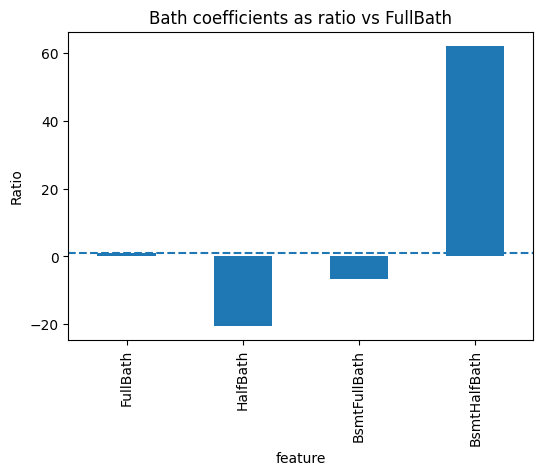

In [214]:
# ==================== Bath comparison: models + ratios (ready to run) ====================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- 1) Build the two models (raw baths vs engineered TotalBaths) ----------------
# Columns we need
bath_cols = [c for c in ["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"] if c in X_fe.columns]
if len(bath_cols) < 3:
    raise ValueError(f"Expected at least 3 of {['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']}, got {bath_cols}")

# RAW model: keep the four bath columns + everything else
cols_raw = bath_cols + [c for c in X_fe.columns if c not in bath_cols]

# TOTAL model: keep TotalBaths + everything else EXCEPT the raw bath columns
if "TotalBaths" not in X_fe.columns:
    raise ValueError("`TotalBaths` column not found in X_fe. Create it before running this block.")

cols_total = ["TotalBaths"] + [c for c in X_fe.columns if c not in (bath_cols + ["TotalBaths"])]

ridge_raw_baths = make_linear_pipe(
    X_fe[cols_raw],
    model="ridge",
    model_kwargs={"alpha": 18.87, "max_iter": 200_000, "tol": 1e-3},
)

ridge_total_baths = make_linear_pipe(
    X_fe[cols_total],
    model="ridge",
    model_kwargs={"alpha": 18.87, "max_iter": 200_000, "tol": 1e-3},
)

# ---------------- 2) Compare with CV ----------------
models = [
    ("Ridge raw baths", ridge_raw_baths),
    ("Ridge engineered TotalBaths", ridge_total_baths),
]
cmp_results = cv_eval_models(X=X_fe, y=y, models=models, cv=5, random_state=42)
display(cmp_results)

# ---------------- 3) Extract bath coefficients & ratios WITHOUT feature-name plumbing ----------------
def bath_ratios_from_raw_model(model, X, bath_features=("FullBath","HalfBath","BsmtFullBath","BsmtHalfBath")) -> pd.DataFrame:
    """
    Robustly locate the transformed-column indices for the *numeric* bath features
    by walking the fitted ColumnTransformer and summing output widths.
    This avoids get_feature_names_out and works even with pipelines (cap/log/scale).
    """
    # unwrap TransformedTargetRegressor if present
    if hasattr(model, "regressor_"):
        pipe = model.regressor_
    else:
        pipe = model
    prep = pipe.named_steps["prep"]
    reg  = pipe.named_steps["reg"]

    # tiny sample (must be a DataFrame with the same columns)
    X_sample = X.iloc[:5, :]

    # We'll advance an offset across transformers and remember where each numeric col lands
    offset = 0
    bath_to_index = {}
    # iterate over fitted transformers (skip drops)
    for name, trans, cols in prep.transformers_:
        if trans == "drop" or cols is None:
            continue

        # Select just these columns for this transformer
        X_sub = X_sample[cols] if isinstance(cols, (list, tuple)) else X_sample[[cols]]

        # Get transformed output to know width
        out = trans.transform(X_sub)
        # out can be dense or sparse; both have .shape
        width = out.shape[1] if out.ndim == 2 else 1

        # If this branch is one of the numeric branches it should preserve 1:1 mapping
        # with its input columns (cap -> impute -> log -> scale keep the same #cols).
        # We can identify that by checking the type: it's a Pipeline and *not* an encoder.
        from sklearn.pipeline import Pipeline as SkPipeline
        is_numeric_branch = isinstance(trans, SkPipeline) and not any(
            step_name in dict(trans.steps) for step_name in ["onehot", "ordinal"]
        )

        if is_numeric_branch and isinstance(cols, (list, tuple)):
            # map each input numeric column to its exact output position
            for i, col in enumerate(cols):
                if col in bath_features:
                    bath_to_index[col] = offset + i

        # advance global offset by this transformer's width
        offset += width

    if not bath_to_index:
        raise RuntimeError("Could not locate bath features in the transformed design matrix.")

    # Pull coefficients from the linear regressor
    coefs = np.ravel(reg.coef_)
    out_rows = []
    for col in bath_features:
        if col in bath_to_index:
            out_rows.append((col, float(coefs[bath_to_index[col]])))
    coef_df = pd.DataFrame(out_rows, columns=["feature", "coef_after_prep"]).set_index("feature")

    # Compute ratios vs FullBath (guard against zero)
    full = coef_df.loc["FullBath", "coef_after_prep"] if "FullBath" in coef_df.index else np.nan
    coef_df["ratio_vs_FullBath"] = coef_df["coef_after_prep"] / full if full not in (0, np.nan) else np.nan

    # Add your "expected" ratios for reference (edit if you want different priors)
    expected = {
        "FullBath": 1.0,
        "HalfBath": 0.5,
        "BsmtFullBath": 1.0,
        "BsmtHalfBath": 0.5,
    }
    coef_df["expected_ratio"] = [expected.get(k, np.nan) for k in coef_df.index]
    return coef_df

# Fit the RAW model on all data so its regressor_.coef_ is available
ridge_raw_baths.fit(X_fe[cols_raw], y)
bath_ratios = bath_ratios_from_raw_model(ridge_raw_baths, X_fe[cols_raw])
display(bath_ratios)

# ---------------- 4) Quick visualization of ratios vs expectation ----------------
if "ratio_vs_FullBath" in bath_ratios.columns:
    plt.figure(figsize=(6,4))
    bath_ratios["ratio_vs_FullBath"].plot(kind="bar")
    plt.axhline(1.0, linestyle="--")   # Full bath reference
    plt.title("Bath coefficients as ratio vs FullBath")
    plt.ylabel("Ratio")
    plt.show()

# ==============================================================================================

,coef_after_prep,ratio_vs_FullBath,expected_ratio
feature,,,
FullBath,-444.440710,1.000000,1.0
HalfBath,1022.262991,-2.300111,0.5
BsmtFullBath,455.162386,-1.024124,1.0
BsmtHalfBath,-3509.379077,7.896169,0.5


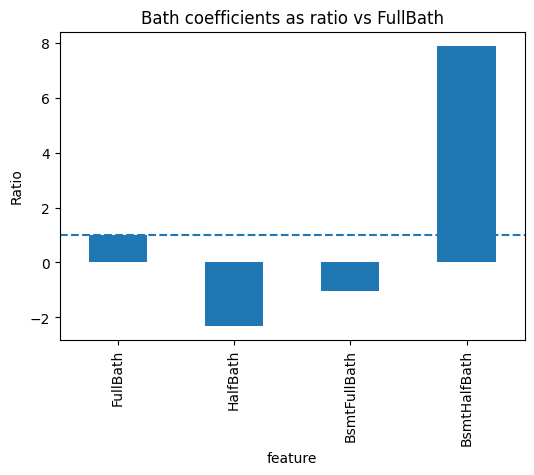

In [135]:
mask = (Ames["BsmtQual"].isin(["TA","Gd","Ex"])) & (Ames["BsmtFinSF1"] > 0)
X_sub, y_sub = X_fe[mask], Ames.loc[mask, "SalePrice"]

# Fit the RAW model on all data so its regressor_.coef_ is available
ridge_raw_baths.fit(X_sub[cols_raw], y_sub)
bath_ratios = bath_ratios_from_raw_model(ridge_raw_baths, X_sub[cols_raw])
display(bath_ratios)

# ---------------- 4) Quick visualization of ratios vs expectation ----------------
if "ratio_vs_FullBath" in bath_ratios.columns:
    plt.figure(figsize=(6,4))
    bath_ratios["ratio_vs_FullBath"].plot(kind="bar")
    plt.axhline(1.0, linestyle="--")   # Full bath reference
    plt.title("Bath coefficients as ratio vs FullBath")
    plt.ylabel("Ratio")
    plt.show()

# ==============================================================================================

In [138]:
X_fe_rule = X_fe.copy()

# weighted rule: Full=1, Half=0.5, BsmtFull=1, BsmtHalf=0.5
X_fe_rule["BathWeighted"] = (
    X_fe_rule["FullBath"]
    + 0.5 * X_fe_rule["HalfBath"]
    + 1.0 * X_fe_rule["BsmtFullBath"]
    + 0.5 * X_fe_rule["BsmtHalfBath"]
)

# drop the original bath columns
X_fe_rule = X_fe_rule.drop(["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"], axis=1)

In [144]:
baths_expected = ["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]
print("Missing:", [c for c in baths_expected if c not in X_fe.columns])
print("Present:", [c for c in baths_expected if c in X_fe.columns])

Missing: []
Present: ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']


In [145]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class BathEngineer(BaseEstimator, TransformerMixin):
    """
    Adds BathWeighted = w_full*Full + w_half*Half + w_bfull*BsmtFull + w_bhalf*BsmtHalf.
    If any source column is missing, it is treated as 0 (no basement baths, etc.).
    Optionally drops whichever of those columns exist.
    """
    def __init__(self,
                 full="FullBath", half="HalfBath",
                 bfull="BsmtFullBath", bhalf="BsmtHalfBath",
                 w_full=1.0, w_half=0.5, w_bfull=1.0, w_bhalf=0.5,
                 drop_original=True):
        self.full, self.half, self.bfull, self.bhalf = full, half, bfull, bhalf
        self.w_full, self.w_half = w_full, w_half
        self.w_bfull, self.w_bhalf = w_bfull, w_bhalf
        self.drop_original = drop_original

    def fit(self, X, y=None):
        self.feature_names_in_ = list(X.columns)
        return self

    def transform(self, X):
        df = X.copy()
        def col_or_zero(col):
            return df[col].fillna(0.0) if col in df.columns else 0.0

        bw = (
            self.w_full  * col_or_zero(self.full)  +
            self.w_half  * col_or_zero(self.half)  +
            self.w_bfull * col_or_zero(self.bfull) +
            self.w_bhalf * col_or_zero(self.bhalf)
        )
        df["BathWeighted"] = bw

        if self.drop_original:
            to_drop = [c for c in [self.full, self.half, self.bfull, self.bhalf] if c in df.columns]
            if to_drop:
                df = df.drop(columns=to_drop)
        return df

In [148]:
def make_ridge_with_bath_rule(df_schema, alpha=18.87,
                              weights=(1.0, 0.5, 1.0, 0.5),
                              drop_original=True):
    # 1) bath feature step (robust version you added earlier)
    bath = BathEngineer(w_full=weights[0], w_half=weights[1],
                        w_bfull=weights[2], w_bhalf=weights[3],
                        drop_original=drop_original)

    # 2) derive the post-bath schema from a tiny slice so CT knows real columns
    schema_after_bath = bath.fit_transform(df_schema.iloc[:5].copy())

    # 3) build preprocessor on the *post-bath* schema
    pre  = build_preprocessor(schema_after_bath, mode="linear")

    # 4) regressor
    reg  = Ridge(alpha=alpha, max_iter=200_000, tol=1e-3)

    # 5) full pipeline wrapped in TTR
    pipe = Pipeline([("bath_feat", bath), ("prep", pre), ("reg", reg)])
    return TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

In [149]:
ridge_raw_baths = make_linear_pipe(
    X_fe, model="ridge", model_kwargs={"alpha": 18.87, "max_iter": 200_000, "tol": 1e-3}
)

ridge_bath_rule = make_ridge_with_bath_rule(
    X_fe, alpha=18.87, weights=(1.0, 0.5, 1.0, 0.5), drop_original=True
)

print(cv_eval_models(X=X_fe, y=y, cv=5, models=[
    ("Ridge raw baths", ridge_raw_baths),
    ("Ridge bath rule (1,0.5,1,0.5)", ridge_bath_rule),
]))

                           model  cv_rmse_mean  cv_rmse_std     r2_cv  \
0  Ridge bath rule (1,0.5,1,0.5)  21612.006941  4510.036676  0.913386   
1                Ridge raw baths  21747.107901  4911.554654  0.911673   

    r2_full  
0  0.938720  
1  0.938429  


In [150]:
ridge_raw_baths = make_linear_pipe(
    X_fe, model="ridge", model_kwargs={"alpha": 18.87, "max_iter": 200_000, "tol": 1e-3}
)

ridge_bath_rule = make_ridge_with_bath_rule(
    X_fe, alpha=18.87, weights=(1.0, 0.5, 1.0, 0.5), drop_original=True
)

print(cv_eval_models(X=X_fe, y=y, cv=10, models=[
    ("Ridge raw baths", ridge_raw_baths),
    ("Ridge bath rule (1,0.5,1,0.5)", ridge_bath_rule),
]))

                           model  cv_rmse_mean  cv_rmse_std     r2_cv  \
0  Ridge bath rule (1,0.5,1,0.5)  21033.862790  5775.464768  0.915454   
1                Ridge raw baths  21106.974758  6224.589642  0.913949   

    r2_full  
0  0.938720  
1  0.938429  


In [166]:
ridge_raw_baths = make_linear_pipe(
    X_fe, model="ridge", model_kwargs={"alpha": 18.87, "max_iter": 200_000, "tol": 1e-3}
)

ridge_bath_rule = make_ridge_with_bath_rule(
    X_fe, alpha=18.87, weights=(1.0, 0.7, 1, 0.7), drop_original=True
)

print(cv_eval_models(X=X_fe, y=y, cv=5, models=[
    ("Ridge raw baths", ridge_raw_baths),
    ("Ridge bath rule (1,0.5,1,0.5)", ridge_bath_rule),
]))

                           model  cv_rmse_mean  cv_rmse_std     r2_cv  \
0  Ridge bath rule (1,0.5,1,0.5)  21602.988016  4507.881340  0.913459   
1                Ridge raw baths  21747.107901  4911.554654  0.911673   

    r2_full  
0  0.938779  
1  0.938429  


In [158]:
def cv_bath_weight_search(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    alpha: float = 18.87,
    half_range=(0.3, 0.7, 0.1),   # search HalfBath weights
    bsmthalf_range=(0.3, 0.7, 0.1), # search BsmtHalfBath weights
    cv: int = 5,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Search over different weights for HalfBath and BsmtHalfBath in BathWeighted.
    """
    rows = []
    half_vals = np.arange(*half_range)
    bsmthalf_vals = np.arange(*bsmthalf_range)

    for half_w in half_vals:
        for bsmthalf_w in bsmthalf_vals:
            # Build BathWeighted column
            X_mod = X.copy()
            X_mod["BathWeighted"] = (
                1.0 * X_mod["FullBath"]
                + half_w * X_mod["HalfBath"]
                + 1.0 * X_mod["BsmtFullBath"]
                + bsmthalf_w * X_mod["BsmtHalfBath"]
            )
            X_mod = X_mod.drop(columns=["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"])

            # Build model
            pipe = make_linear_pipe(
                X_mod, model="ridge",
                model_kwargs={"alpha": alpha, "max_iter": 200_000, "tol": 1e-3}
            )

            # Evaluate
            res = cv_eval_models(X_mod, y, models=[(f"Rule half={half_w}, bsmthalf={bsmthalf_w}", pipe)],
                                 cv=cv, random_state=random_state)
            row = {
                "half_w": half_w,
                "bsmthalf_w": bsmthalf_w,
                "cv_rmse_mean": res.iloc[0]["cv_rmse_mean"],
                "cv_rmse_std":  res.iloc[0]["cv_rmse_std"],
                "r2_cv":        res.iloc[0]["r2_cv"],
                "r2_full":      res.iloc[0]["r2_full"],
            }
            rows.append(row)

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [215]:
grid_results = cv_bath_weight_search(X_fe, y, half_range=(0.3,0.8,0.1), bsmthalf_range=(0.3,0.8,0.1), cv=5)
display(grid_results.head(10))

,half_w,bsmthalf_w,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,0.7,0.7,21725.429383,4917.494391,0.911830,0.938277
1,0.7,0.6,21727.706944,4920.568842,0.911807,0.938272
2,0.6,0.7,21728.137276,4917.620487,0.911809,0.938263
3,0.6,0.6,21730.115320,4921.475336,0.911787,0.938253
4,0.5,0.7,21731.422796,4917.183937,0.911784,0.938253
5,0.7,0.5,21731.634935,4924.164448,0.911770,0.938262
6,0.5,0.6,21732.996714,4921.244333,0.911765,0.938241
7,0.6,0.5,21733.590553,4925.748577,0.911752,0.938241
8,0.4,0.7,21734.012770,4916.516600,0.911765,0.938251
9,0.4,0.6,21735.198471,4920.319221,0.911749,0.938238


In [177]:
half_weight = grid_results.head(1)['half_w'][0]
b_weight_half = grid_results.head(1)['bsmthalf_w'][0]

In [219]:
# --- add to your one-cell utilities ---
from sklearn.base import BaseEstimator, RegressorMixin, clone

class WeightedBlend(BaseEstimator, RegressorMixin):
    """
    Blend two regressors with a fixed weight: yhat = w1 * est1(x) + (1-w1) * est2(x).
    Works with full pipelines (incl. TTR) as long as both predict in $-space.
    """
    def __init__(self, est1, est2, w1=0.5):
        self.est1 = est1
        self.est2 = est2
        self.w1 = w1

    def fit(self, X, y):
        # clone to keep fold-safe & avoid refitting original objects
        self.est1_ = clone(self.est1)
        self.est2_ = clone(self.est2)
        self.est1_.fit(X, y)
        self.est2_.fit(X, y)
        return self

    def predict(self, X):
        p1 = self.est1_.predict(X)
        p2 = self.est2_.predict(X)
        return self.w1 * p1 + (1.0 - self.w1) * p2

def make_blend_pipe(*, ridge, hgb, w_ridge=0.4):
    """Convenience wrapper to build a WeightedBlend from your tuned ridge & HGB."""
    return WeightedBlend(est1=ridge, est2=hgb, w1=w_ridge)

In [220]:
# define the base models (you already had these)
ridge_raw = make_linear_pipe(
    X_fe, model="ridge",
    model_kwargs={"alpha": 18.87}  # no max_iter/tol; factory already sets them
)

hgb_tuned = make_histgb_pipe(
    X_fe,
    hgb_kwargs={
        "random_state": 42,
        "max_depth": 3,
        "max_leaf_nodes": 36,
        "min_samples_leaf": 29,
        "max_bins": 203,
        "learning_rate": 0.0186599596,
        "l2_regularization": 1.874022e-07,
        "max_iter": 1500
    }
)

# blends
blend_4060 = make_blend_pipe(ridge=ridge_raw, hgb=hgb_tuned, w_ridge=0.40)
blend_3565 = make_blend_pipe(ridge=ridge_raw, hgb=hgb_tuned, w_ridge=0.35)

# evaluate
print(cv_eval_models(
    X=X_fe, y=y, cv=5, models=[
        ("Ridge raw", ridge_raw),
        ("HGB tuned", hgb_tuned),
        ("Blend 40/60", blend_4060),
        ("Blend 35/65", blend_3565),
    ]
).to_string(index=False))

      model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
Blend 40/60  20603.913170  3892.311946 0.921871 0.960089
Blend 35/65  20619.386870  3818.658197 0.921858 0.961188
  HGB tuned  21208.748432  3381.116207 0.918037 0.965895
  Ridge raw  21746.994992  4911.509870 0.911674 0.938429
